# 0. Required dependencies
Same as the provided start_here file

In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook
%matplotlib inline

In [2]:
# dataset filepath constant
dataset_path = './vub-ml-project-2024-animal-classification/'
# where do you want to save your features and other outputs:
output_path = './vub-ml-project-2024-animal-classification/output/'

In [3]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

print(f"dataset_path_train: {dataset_path_train}")

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')
print(f"Creating path: {features_path}")

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

dataset_path_train: ./vub-ml-project-2024-animal-classification/train
Creating path: ./vub-ml-project-2024-animal-classification/output/features


# 1. Loading the data and the labels
First, we'll get the training labels. The train data is ordered in a way such that all images in a class are stored in a separate folder, thus we can simply get a string represenation of the labels by using the folder names.

In [4]:
path1 = os.getcwd()
path = dataset_path_train
print("Working Directory: ", path1, "Path: ", path)

folder_path1 = os.path.join(dataset_path_train,'*')
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))

label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]
print("Number of classes:",num_classes)
print("\nLabels: \n", label_strings)


Working Directory:  C:\Users\sojij\WPO\ML\PROJECT\starterskit Path:  ./vub-ml-project-2024-animal-classification/train
Number of classes: 12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


**Building dictionary of the filepath**
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [5]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

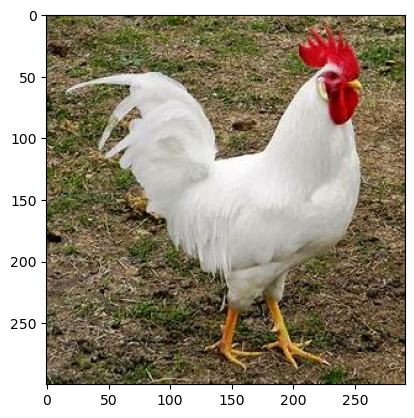

In [6]:
# load first image of class chicken using opencv:
image = cv2.imread(train_paths['chicken'][0])

# images can be plotted using matplotlib, but need to be converted from BGR to RGB
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Looking at the data
Next, we plot the first 3 images of each class to get a first impression on what our data looks like.

Image shape: (300, 291, 3)


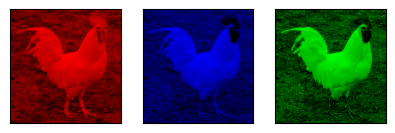

In [7]:
# blue, green and red channels are aligned along the third dimension of the returned numpy array
print('Image shape: {}'.format(image.shape))


# compute aspect ratio of image 
(height, width, nr_channels) = image.shape

aspect_ratio = width / float(height)

fig_height = 5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(fig_height * aspect_ratio, fig_height))
[ax.get_xaxis().set_visible(False) for ax in axes]
[ax.get_yaxis().set_visible(False) for ax in axes]
ax0, ax1, ax2 = axes

# extract blue, green and red channels from image
blue_channel = image[:, :, 0]
green_channel = image[:, :, 1]
red_channel = image[:, :, 2]

ax0.imshow(np.dstack([red_channel, np.zeros_like(blue_channel), np.zeros_like(blue_channel)]))
ax1.imshow(np.dstack([np.zeros_like(green_channel), np.zeros_like(green_channel), green_channel]))
ax2.imshow(np.dstack([np.zeros_like(red_channel), blue_channel, np.zeros_like(red_channel)]))

plt.show()

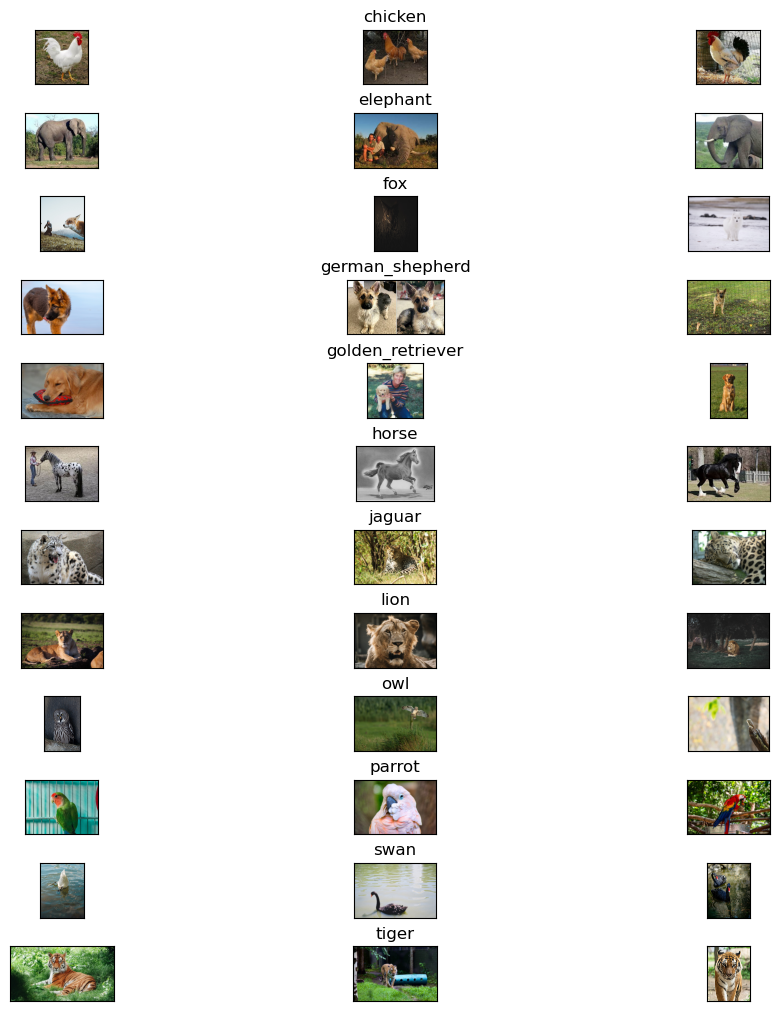

In [8]:
fig, axes = plt.subplots(nrows=num_classes, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:3]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

# Preliminary Data analysis
There are 12 different classes in this supervised multiclass classification problem. We'll start with calculating number of images for each of the classes.

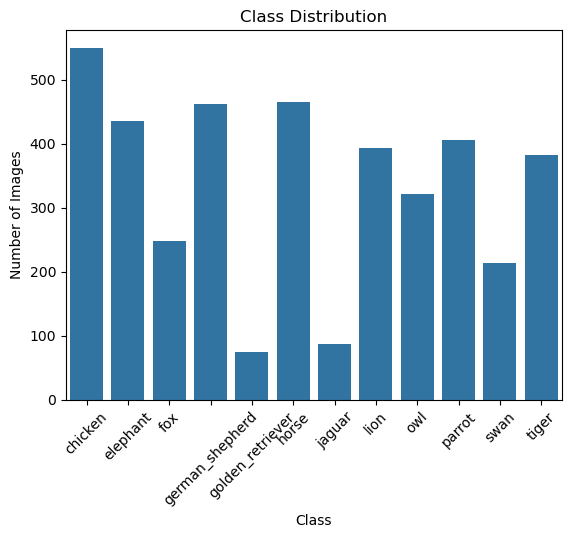

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

# Visualize class distribution
def plot_class_distribution(train_paths):
    class_counts = {label: len(paths) for label, paths in train_paths.items()}
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()


# Call the functions
plot_class_distribution(train_paths)
#display_sample_images(train_paths)


# 3. Using feature descriptor
The dataset provided contains raw image features before the creation of clusters and the counting of the visual words. 
We simply load the extracted features from disk. They are stored as pickle files, which are just files serialized for python.

In [10]:
descriptor_desired = 'daisy'

start = time.time()
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

end = time.time()
print(f'Loading Train and Test features took {end - start:.2f} seconds. Descriptor used: {descriptor_desired}')

print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))


Loading Train and Test features took 12.43 seconds. Descriptor used: daisy
Number of encoded train images: 4042
Number of encoded test images: 4035


The next thing we need to do is to cluster the training features into the words that will construct our dictionary. 
Note that the number of categories (words) is a hyperparameter that should be optimised, ideally with grid search.

The functions we use below are implemented in the 'helpers' library. Our kind thanks go out to the authors of [https://github.com/flytxtds/scene-recognition](https://github.com/flytxtds/scene-recognition), from where this code has been adapted. 

The code below creates the desired encoded BoW feature vector.

In [11]:
# learn the codebook for the previously selected descriptor  features from the training data

codebook_size = 1000

clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)



C:\Users\sojij\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


training took 131.14655208587646 seconds


In [12]:
# encode all train and test images 
train_data = []
train_labels = []
test_data = []
start = time.time()
for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
end = time.time()
print(f'Encoding Train features took {end - start:.2f} seconds.')

start = time.time()
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)
end = time.time()
print(f'Encoding Test features took {end - start:.2f} seconds.')


Encoding Train features took 15.29 seconds.
Encoding Test features took 17.41 seconds.


Now that we have readily useable train and test data matrices, there is only one thing missing: our label vector still contains string representations of our labels, but in order to train a supervised classifier, we need the labels to be represented as integers of course. The <code>LabelEncoder</code> class of sklearn does exactly that.

In [13]:
# use a labelencoder to obtain numerical labels
label_encoder = sklearn.preprocessing.LabelEncoder()
print("\nLabels before calling label_encoder.fit: \n", label_strings)
label_encoder.fit(label_strings)
print(train_labels[:10])
print("len(train_labels):", len(train_labels))
train_labels = label_encoder.transform(train_labels)
print("len(train_labels):", len(train_labels))
print(train_labels[:10])


Labels before calling label_encoder.fit: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
len(train_labels): 4042
len(train_labels): 4042
[0 0 0 0 0 0 0 0 0 0]


In [14]:
# print the obtained feature vectors with their labels for a quick look
X = pd.DataFrame(train_data)
y = pd.DataFrame(train_labels)

# have a truncated look at the data
X.head()



,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.044947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.146254,0.0,0.0,0.073127,0.146254,0.0,0.0,0.0,0.0,0.146254,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.044368,0.044368,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.171499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# print the obtained feature vectors with their labels for a quick look
data = np.c_[X, y]
print(pd.RangeIndex(start=1, stop=codebook_size+1, step=1))
columns = np.append(X.columns, ["target"])
pd_data = pd.DataFrame(data, columns=columns)

# have a truncated look at the data
pd_data.head()

RangeIndex(start=1, stop=1001, step=1)


,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,target
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.146254,0.0,0.0,0.073127,0.146254,0.0,0.0,0.0,0.0,0.146254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.044368,0.044368,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# missing values check
missing = 0
for col in pd_data.columns:
    if(pd_data[col].isnull().any()):
        print(col,'has missing values')
        missing = 1
if(missing==0):
    print('There are no missing values')

There are no missing values


#  Split into validation (QA) set(s) and test set(s)
As per requirement, the test data can not be used for optimization. So we need to split the training data a second time into a training set and a validation set (called 'QA' in this program).

This splitting could benefit from fine-tuning. See inline comment to check wether or not it has been fine-tuned. It is chosen to take into account the unbalance of the dataset given. More information in section: Fine-tuning the validation set

In [17]:

#As per requirement, the test data can not be used for optimization. So we need to split the training data a second time into a training set and a validation set.
optima_qa_fraction = 0.15
optima_qa_fraction_balanced = True

qa_fraction = optima_qa_fraction
balanced = optima_qa_fraction_balanced

start = time.time()
if balanced:
    train_data_split, train_qa_data_split, train_labels_split, train_qa_labels_split = train_test_split(train_data, train_labels, test_size = qa_fraction, stratify=train_labels)
else:
    train_data_split, train_qa_data_split, train_labels_split, train_qa_labels_split = train_test_split(train_data, train_labels, test_size = qa_fraction, random_state=0)
end = time.time()
print(f'Encoding Train_QA features took {end - start:.2f} seconds.')

#validating the split
#print("Train labels: ", train_labels_split[:2])
#print("\nTrain data: \n", train_data_split[:2])



Encoding Train_QA features took 0.01 seconds.


# Training the model
We can now start with training our model.

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

# Step 1: Scale data
scaler = StandardScaler()
train_data_split_scaled = scaler.fit_transform(train_data_split)
train_qa_data_split_scaled = scaler.transform(train_qa_data_split)
test_data_scaled = scaler.transform(test_data)

# Step 2: Create an SVM model
svm_params = {
    'C': 1.0,              # Regularization parameter
    'kernel': 'rbf',       # Radial Basis Function kernel
    'probability': True,   # Enable probability estimates
    'random_state': 42     # For reproducibility
}
model = SVC(**svm_params)

# Step 3: Train the SVM model
start = time.time()
model.fit(train_data_split_scaled, train_labels_split)
end = time.time()

# Step 4: Make predictions
predictions_train = model.predict(train_data_split_scaled)
predictions_probability_train = model.predict_proba(train_data_split_scaled)

predictions_train_qa = model.predict(train_qa_data_split_scaled)
predictions_probability_train_qa = model.predict_proba(train_qa_data_split_scaled)

# Step 5: Evaluate model performance
train_log_loss = log_loss(train_labels_split, predictions_probability_train)
train_qa_log_loss = log_loss(train_qa_labels_split, predictions_probability_train_qa)

train_accuracy = accuracy_score(train_labels_split, predictions_train)
train_qa_accuracy = accuracy_score(train_qa_labels_split, predictions_train_qa)

# Step 6: Output results
print('SVM Classifier Model took {:.2f} seconds'.format(end - start))
print("Train log_loss:", train_log_loss)
print("Train_QA log_loss:", train_qa_log_loss)
print("Train Accuracy:", train_accuracy)
print("Train_QA Accuracy:", train_qa_accuracy)

# Step 7: Test data predictions
predictions_probability_final_test_data = model.predict_proba(test_data_scaled)

# Writing predictions to CSV
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('svm_predictions', 'csv'))
helpers.writePredictionsToCsv(predictions_probability_final_test_data, pred_file_path, label_strings)


SVM Classifier Model took 54.60 seconds
Train log_loss: 0.35967460106778165
Train_QA log_loss: 1.3544915953536454
Train Accuracy: 0.9155749636098981
Train_QA Accuracy: 0.5024711696869851


# FINAL - Making a submission
Now use the test data on the trained model and call the helpers.writePredictionsToCsv function to write out predictions as a csv file ready to be submitted to the competition page.

In [19]:
# Check predictions_probability_test shape
print("Shape of predictions_train:", predictions_train.shape)
print("Shape of predictions_probability_train:", predictions_probability_train.shape)
print("Shape of predictions_train_qa:", predictions_train_qa.shape)
print("Shape of predictions_probability_train_qa:", predictions_probability_train_qa.shape)
print("len(predictions_train):", len(predictions_train))
print("len(predictions_probability_train):", len(predictions_probability_train))
print("len(predictions_train_qa):", len(predictions_train_qa))
print("len(predictions_probability_train_qa):", len(predictions_probability_train_qa))
print("len(train_paths):", len(train_paths))
print("len(test_paths):", len(test_paths))


# Do predictions on the actual test data
predictions_probability_final_test_data = model.predict_proba(test_data)

# Ensure predictions_probability_test matches the number of test paths
#if len(predictions_probability_test) != len(test_paths):
#    raise ValueError("Mismatch between number of predictions and test paths.")

# Build the submission file
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('prior_probas', 'csv'))

# Writing predictions to CSV
helpers.writePredictionsToCsv(predictions_probability_final_test_data, pred_file_path, label_strings)

print(f"Predictions written to {pred_file_path}")

Shape of predictions_train: (3435,)
Shape of predictions_probability_train: (3435, 12)
Shape of predictions_train_qa: (607,)
Shape of predictions_probability_train_qa: (607, 12)
len(predictions_train): 3435
len(predictions_probability_train): 3435
len(predictions_train_qa): 607
len(predictions_probability_train_qa): 607
len(train_paths): 12
len(test_paths): 4035
Predictions written to ./vub-ml-project-2024-animal-classification/output/predictions\prior_probas_20250115-224506.csv


CONFUSION MATRIX


Confusion Matrix:


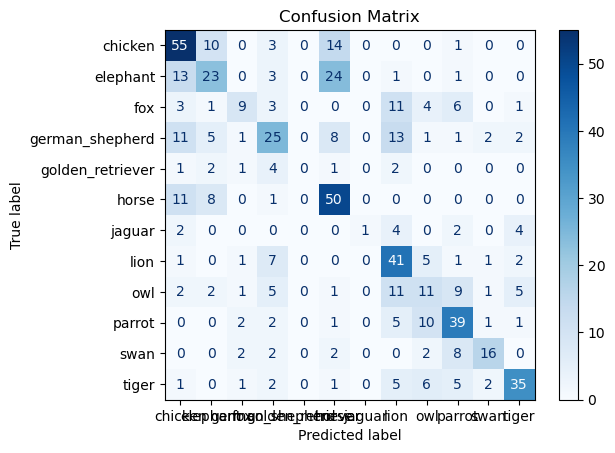


Classification Report:
                  precision    recall  f1-score   support

         chicken     0.5500    0.6627    0.6011        83
        elephant     0.4510    0.3538    0.3966        65
             fox     0.5000    0.2368    0.3214        38
 german_shepherd     0.4386    0.3623    0.3968        69
golden_retriever     0.0000    0.0000    0.0000        11
           horse     0.4902    0.7143    0.5814        70
          jaguar     1.0000    0.0769    0.1429        13
            lion     0.4409    0.6949    0.5395        59
             owl     0.2821    0.2292    0.2529        48
          parrot     0.5342    0.6393    0.5821        61
            swan     0.6957    0.5000    0.5818        32
           tiger     0.7000    0.6034    0.6481        58

        accuracy                         0.5025       607
       macro avg     0.5069    0.4228    0.4204       607
    weighted avg     0.5050    0.5025    0.4835       607

Per-class Metrics:
Class 'chicken': Precision

C:\Users\sojij\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sojij\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sojij\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


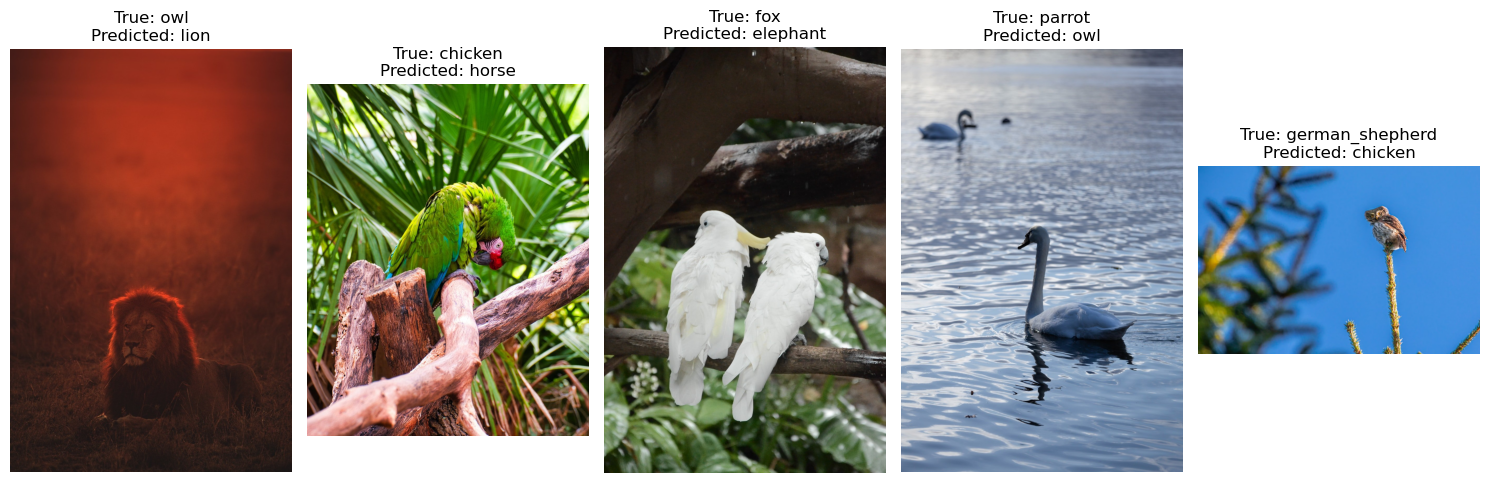

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 8: Generate confusion matrix
conf_matrix = confusion_matrix(train_qa_labels_split, predictions_train_qa)

# Display confusion matrix
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_strings)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 9: Compute classification report
print("\nClassification Report:")
class_report = classification_report(
    train_qa_labels_split,
    predictions_train_qa,
    target_names=label_strings,
    digits=4
)
print(class_report)

# Parse classification report for per-class accuracy, precision, recall, and F1-score
print("Per-class Metrics:")
for i, label in enumerate(label_strings):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fn + fp)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print(
        f"Class '{label}': Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1_score:.4f}"
    )

# Step 10: Visualize misclassified images
def visualize_misclassified_images(images, true_labels, predicted_labels, num_samples=5):
    misclassified_indices = np.where(true_labels != predicted_labels)[0]
    num_misclassified = len(misclassified_indices)
    
    print(f"\nNumber of misclassified images: {num_misclassified}")
    if num_misclassified == 0:
        print("No misclassifications to visualize!")
        return

    # Randomly select a subset of misclassified images to visualize
    sample_indices = np.random.choice(misclassified_indices, size=min(num_samples, num_misclassified), replace=False)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        img = test_paths[idx]
        true_label = label_strings[true_labels[idx]]
        predicted_label = label_strings[predicted_labels[idx]]
        
        plt.subplot(1, num_samples, i + 1)
        img_data = cv2.imread(img)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        plt.imshow(img_data)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function to visualize misclassified images
visualize_misclassified_images(
    images=test_paths,
    true_labels=train_qa_labels_split,
    predicted_labels=predictions_train_qa,
    num_samples=5
)
